# Experiment Analysis

## Loading the CSV file

In [11]:
import pandas as pd

df = pd.read_csv("../data/final_experiment_dataset.csv")
final_experiment_df = df.copy()
final_experiment_df.head(5)

,client_id,Variation,clnt_tenure_yr,clnt_tenure_mnth,clnt_age,gendr,num_accts,bal,calls_6_mnth,logons_6_mnth,merged_session_id,converted,first_time,last_time,total_duration_sec,n_events,n_attempts,n_errors,any_anomaly
0,9988021,Test,5.0,64.0,79.0,U,2.0,189023.86,1.0,4.0,1,False,2017-04-12 16:57:27,2017-04-17 15:27:07,426580.0,15,1,2,False
1,8320017,Test,22.0,274.0,34.5,M,2.0,36001.90,5.0,8.0,1,True,2017-04-05 13:08:06,2017-04-05 13:10:05,119.0,5,1,0,False
2,4033851,Control,12.0,149.0,63.5,M,2.0,142642.26,5.0,8.0,1,True,2017-04-05 12:04:00,2017-04-05 12:29:03,1503.0,15,1,3,True
3,1982004,Test,6.0,80.0,44.5,U,2.0,30231.76,1.0,4.0,1,True,2017-04-17 11:59:42,2017-04-17 12:02:42,180.0,5,1,0,False
4,9294070,Control,5.0,70.0,29.0,U,2.0,34254.54,0.0,3.0,1,False,2017-04-17 11:16:13,2017-04-17 11:16:28,15.0,2,1,0,False


In [12]:
final_experiment_df.shape

(56252, 19)

## Controlling for bias between groups

In [13]:
final_experiment_df["Variation"].value_counts()

Variation
Test       29970
Control    26282
Name: count, dtype: int64

In [14]:
final_experiment_df.groupby("Variation")[[
    "clnt_age",
    "clnt_tenure_yr",
    "num_accts",
    "calls_6_mnth",
    "logons_6_mnth"
]].mean()


,clnt_age,clnt_tenure_yr,num_accts,calls_6_mnth,logons_6_mnth
Variation,,,,,
Control,47.819667,12.151168,2.266875,3.200099,6.236664
Test,47.652886,12.092659,2.257424,3.139206,6.178545


In [15]:
# Baseline demographics and engagement metrics are well balanced between the control and test groups, indicating successful random assignment and low risk of selection bias.

In [16]:
from scipy.stats import ttest_ind

ctrl = final_experiment_df[final_experiment_df["Variation"] == "Control"]["clnt_age"]
test = final_experiment_df[final_experiment_df["Variation"] == "Test"]["clnt_age"]

ttest_ind(ctrl, test, nan_policy="omit")


TtestResult(statistic=np.float64(1.2676830202856066), pvalue=np.float64(0.20491641833028748), df=np.float64(56250.0))

p-value ≈ 0.205
This is well above common thresholds (0.05 or 0.01).

Interpretation
We fail to reject the null hypothesis that the mean age is the same in Control and Test.

What that means here:
There is no statistically significant age difference between the two groups.
That supports good randomization and low selection bias.

## KPIs

### Client level diagnostics

- KPI #1: Conversion Rate: We define "Coversion Rate" as the ratio between successful completion of sessions (from start to confirm) compared to the total amount ot sessions initiated. 

In [17]:
# for that we need to group by "Variation" and check for "converted", calculating the mean(), and hsowing it by percentage
conversion_by_group = final_experiment_df.groupby("Variation")["converted"].mean()

(conversion_by_group * 100).round(2)

Variation
Control    53.88
Test       63.74
Name: converted, dtype: float64

In [18]:
# now let's test for the statistical significance of our result
import numpy as np

conv_table = (
    final_experiment_df
    .groupby("Variation")["converted"]
    .agg(["sum", "count"])
)

conv_table

x_test  = conv_table.loc["Test", "sum"]
n_test  = conv_table.loc["Test", "count"]

x_ctrl  = conv_table.loc["Control", "sum"]
n_ctrl  = conv_table.loc["Control", "count"]

from statsmodels.stats.proportion import proportions_ztest

stat, pval = proportions_ztest(
    count=np.array([x_test, x_ctrl]),
    nobs=np.array([n_test, n_ctrl]),
    alternative="two-sided"
)

stat, pval


(np.float64(23.73233566793729), np.float64(1.6724270218096497e-124))

In [19]:
# Our null hypothesis is that the difference in the conversion rate in not significant. 
# after running our statistical test above, we can see that we get an incredibly small p-value, much lower than 0.05.
# hence our result is significant.

- KPI #2: Average Total Time to Completion: What is average time duration that takes a converting customer to complete a session.

In [21]:
converters_df = final_experiment_df[final_experiment_df["converted"]].copy()
converters_df

,client_id,Variation,clnt_tenure_yr,clnt_tenure_mnth,clnt_age,gendr,num_accts,bal,calls_6_mnth,logons_6_mnth,merged_session_id,converted,first_time,last_time,total_duration_sec,n_events,n_attempts,n_errors,any_anomaly
1,8320017,Test,22.0,274.0,34.5,M,2.0,36001.90,5.0,8.0,1,True,2017-04-05 13:08:06,2017-04-05 13:10:05,119.0,5,1,0,False
2,4033851,Control,12.0,149.0,63.5,M,2.0,142642.26,5.0,8.0,1,True,2017-04-05 12:04:00,2017-04-05 12:29:03,1503.0,15,1,3,True
3,1982004,Test,6.0,80.0,44.5,U,2.0,30231.76,1.0,4.0,1,True,2017-04-17 11:59:42,2017-04-17 12:02:42,180.0,5,1,0,False
6,3170143,Test,21.0,254.0,53.5,F,2.0,192109.59,6.0,9.0,1,True,2017-04-04 18:38:02,2017-04-04 18:41:44,222.0,5,1,0,False
10,5887227,Test,6.0,79.0,32.5,U,2.0,60274.39,1.0,4.0,1,True,2017-04-05 14:45:14,2017-04-05 14:52:34,440.0,7,1,0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56243,8692087,Test,14.0,179.0,60.5,F,3.0,85826.90,4.0,7.0,2,True,2017-03-29 17:16:08,2017-03-29 17:29:18,790.0,15,1,3,True
56246,5305116,Control,18.0,226.0,63.5,F,3.0,89726.65,2.0,5.0,2,True,2017-04-20 09:25:23,2017-04-20 09:30:11,288.0,5,1,0,False
56247,393005,Control,15.0,191.0,52.5,M,2.0,60344.67,1.0,4.0,1,True,2017-03-29 15:25:20,2017-03-29 15:46:16,1256.0,11,1,3,False
56250,5230357,Test,23.0,278.0,30.5,M,2.0,61349.70,0.0,3.0,1,True,2017-04-19 11:23:05,2017-04-19 11:24:46,101.0,5,1,0,False


In [26]:
converters_df["total_duration_sec"].max()

8373949.0

In [71]:
# by checking the ax value of "total_duration_sec" we understand that there are some outliers in our groups that are driving the avergages to crazy levels. Therefore we need to find them and exclude them,
q1 = converters_df["total_duration_sec"].quantile(0.25)
q3 = converters_df["total_duration_sec"].quantile(0.75)
iqr = q3 - q1

lower = q1 - 1.5 * iqr
upper = q3 + 1.5 * iqr

q1, q3, iqr, lower, upper


(np.float64(167.0),
 np.float64(697.0),
 np.float64(530.0),
 np.float64(-628.0),
 np.float64(1492.0))

In [72]:
# therefore we take as the absolute uppoer limit of session duration the 1492 seconds.
outliers = converters_df[
    (converters_df["total_duration_sec"] < lower) |
    (converters_df["total_duration_sec"] > upper)
]

outliers.shape


(5679, 19)

In [73]:
# and we will remove those rows
conv_no_outliers_df = converters_df[
    (converters_df["total_duration_sec"] >= lower) &
    (converters_df["total_duration_sec"] <= upper)
].copy()

conv_no_outliers_df.shape

(27587, 19)

In [74]:
avg_time_by_group = conv_no_outliers_df.groupby("Variation")["total_duration_sec"].mean()
avg_time_by_group

Variation
Control    341.325076
Test       313.267769
Name: total_duration_sec, dtype: float64

In [50]:
# i will convert that to minutes
(avg_time_by_group / 60).round(2)

Variation
Control    5.69
Test       5.22
Name: total_duration_sec, dtype: float64

In [53]:
# now let's test for the statistical significance of our result
test_time = conv_no_outliers[conv_no_outliers["Variation"] == "Test"]["total_duration_sec"].values
ctrl_time = conv_no_outliers[conv_no_outliers["Variation"] == "Control"]["total_duration_sec"].values

import numpy as np

n_boot = 10000
boot_diffs = []

for _ in range(n_boot):
    boot_test = np.random.choice(test_time, size=len(test_time), replace=True)
    boot_ctrl = np.random.choice(ctrl_time, size=len(ctrl_time), replace=True)
    boot_diffs.append(boot_test.mean() - boot_ctrl.mean())

boot_diffs = np.array(boot_diffs)

ci_low, ci_high = np.percentile(boot_diffs, [2.5, 97.5])
ci_low, ci_high


(np.float64(-34.28716815995615), np.float64(-21.891496316520325))

In [54]:
# the value of "0" is not between ci_low and ci_high, which makes our result statistically significant.

In [56]:
# checking our interpretation with the p-value
p_value = np.mean(np.abs(boot_diffs) <= 0)
p_value


np.float64(0.0)

- KPI #3: STD of Total Time to Completion: A smooth UI reduced variability.

In [61]:
std_per_group = conv_no_outliers_df.groupby("Variation")["total_duration_sec"].std()

(std_per_group / 60).round(2)

Variation
Control    4.31
Test       4.47
Name: total_duration_sec, dtype: float64

In [ ]:
# our null hypothesis is that there is NO significant difference in standard deviation between the two groups

In [62]:
from scipy.stats import levene

test_time = conv_no_outliers[conv_no_outliers["Variation"] == "Test"]["total_duration_sec"]
ctrl_time = conv_no_outliers[conv_no_outliers["Variation"] == "Control"]["total_duration_sec"]

stat, pval = levene(test_time, ctrl_time)
stat, pval


(np.float64(2.7923507135371954), np.float64(0.0947265372306685))

In [63]:
# with a p-value > 0.05, we fail to reject th null hypothesis. Therefore, we cannot say that the standard deviation in the test group is bigger with statistical significance. We cannot rule out random variation.

- KPI #4: Average number of events (steps) per client: more steps indicate confusion with the UI.

In [68]:
final_experiment_df["n_events"].nunique()

55

In [65]:
# let's explore for outliers
q1_a = final_experiment_df["n_events"].quantile(0.25)
q3_a = final_experiment_df["n_events"].quantile(0.75)
iqr_a = q3_a - q1_a

lower_a = q1_a - 1.5 * iqr_a
upper_a = q3_a + 1.5 * iqr_a

lower_a, upper_a

(np.float64(-0.5), np.float64(11.5))

In [69]:
# therefore we take as the absolute uppoer limit of session duration the 11.5 seconds.
outliers_events = final_experiment_df[
    (final_experiment_df["n_events"] < lower_a) |
    (final_experiment_df["n_events"] > upper_a)
]

outliers_events.shape

(3080, 19)

In [76]:
# and we will remove those rows
attempts_per_client_df = final_experiment_df[
    (final_experiment_df["total_duration_sec"] >= lower) &
    (final_experiment_df["total_duration_sec"] <= upper)
].copy()

attempts_per_client_df.shape

(46463, 19)

In [78]:
attempts_per_client = attempts_per_client_df.groupby("Variation")["n_events"].mean()
attempts_per_client

Variation
Control    4.613899
Test       5.052548
Name: n_events, dtype: float64

In [82]:
# statistical test to undersatnd significance
import numpy as np

test_attempts = final_experiment_df[
    final_experiment_df["Variation"] == "Test"
]["n_events"].values

ctrl_attempts = final_experiment_df[
    final_experiment_df["Variation"] == "Control"
]["n_events"].values

n_boot = 10000
boot_diffs_2 = []

for _ in range(n_boot):
    boot_test = np.random.choice(test_attempts, size=len(test_attempts), replace=True)
    boot_ctrl = np.random.choice(ctrl_attempts, size=len(ctrl_attempts), replace=True)
    boot_diffs_2.append(boot_test.mean() - boot_ctrl.mean())

boot_diffs_2 = np.array(boot_diffs_2)

ci_low, ci_high = np.percentile(boot_diffs_2, [2.5, 97.5])
ci_low, ci_high


(np.float64(0.4902132960142243), np.float64(0.6062527080767707))

In [84]:
p_value = np.mean(np.abs(boot_diffs_2) <= 0)
print(f"p-value = {p_value:.2e}")

p-value = 0.00e+00


In [85]:
# since "0" is not part of our ci_low and ci_high, then the difference in n_events is statistically significant.

### Step-level diagnostics

- KPI #5: Time per step: useful to identify bootlenecks and moments where the user struggles with the UI.

- KPI #6: Drop-off rate per step: Where do users mostly abandon?

In [13]:

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

final_per_step_dataset = pd.read_csv("../data/final_per_step_dataset.csv")


print(len(final_per_step_dataset))

317123


In [47]:
final_per_step_df = final_per_step_dataset.copy()

In [15]:
# Find the maximum step each session reached
max_steps = final_per_step_dataset.groupby(['client_id', 'visitor_id'])['process_step_num'].max()

print(f"Total sessions: {len(max_steps)}")
print(f"Maximum step in data: {max_steps.max()}")

# Count how many sessions reached each step
step_counts = []

for step_num in range(1, int(max_steps.max()) + 1):     # Count how many sessions reached this step
    count = (max_steps >= step_num).sum()
    step_counts.append(count)
    print(f"Step {step_num}: {count} sessions")


Total sessions: 56356
Maximum step in data: 4
Step 1: 48381 sessions
Step 2: 43809 sessions
Step 3: 40543 sessions
Step 4: 35205 sessions


In [17]:
# New a dataframe with results

dropoff_data = []

for i in range(len(step_counts) - 1):
    step_num = i + 1
    sessions_at_step = step_counts[i]
    sessions_at_next_step = step_counts[i + 1]
    
    # Calculate how many dropped
    dropped = sessions_at_step - sessions_at_next_step
    
    # Calculate percentage
    dropoff_rate = (dropped / sessions_at_step) * 100
    
    dropoff_data.append({
        'Step': step_num,
        'Sessions at step': sessions_at_step,
        'Dropped': dropped,
        'Drop-off rate (%)': dropoff_rate
    })

dropoff_df = pd.DataFrame(dropoff_data)
print(dropoff_df)                             

   Step  Sessions at step  Dropped  Drop-off rate (%)
0     1             48381     4572           9.449991
1     2             43809     3266           7.455089
2     3             40543     5338          13.166268


A funnel visualizes users moving through sequential steps : it identifies where users abandon the process

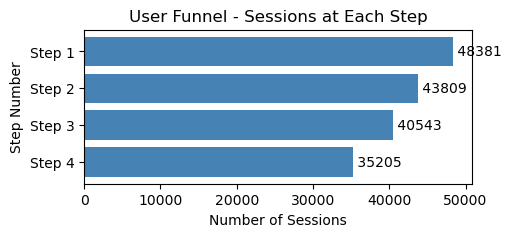

In [44]:
# 1: Number of sessions at each step
plt.figure(figsize=(5, 2))
plt.barh(range(len(step_counts)), step_counts, color='steelblue')
plt.ylabel('Step Number')
plt.xlabel('Number of Sessions')
plt.title('User Funnel - Sessions at Each Step')
plt.yticks(range(len(step_counts)), [f'Step {i+1}' for i in range(len(step_counts))])
plt.gca().invert_yaxis()

# Add numbers on bars
for i, count in enumerate(step_counts):
    plt.text(count, i, f' {count}', va='center')

plt.show()

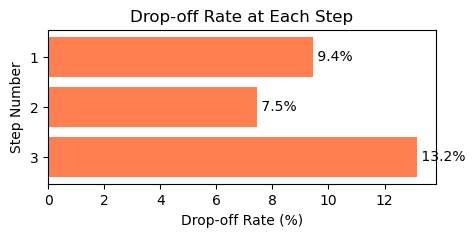

In [45]:
# 22: Drop-off rate
plt.figure(figsize=(5, 2))
plt.barh(dropoff_df['Step'], dropoff_df['Drop-off rate (%)'], color='coral')
plt.xlabel('Drop-off Rate (%)')
plt.ylabel('Step Number')
plt.title('Drop-off Rate at Each Step')
plt.yticks(dropoff_df['Step'])
plt.gca().invert_yaxis()

# Add percentages on bars
for i, row in dropoff_df.iterrows():
    plt.text(row['Drop-off rate (%)'], row['Step'], f' {row["Drop-off rate (%)"]:.1f}%', va='center')

plt.show()

In [22]:
# Find steps with highest drop-off

high_dropoff = dropoff_df[dropoff_df['Drop-off rate (%)'] > 20]     # test value

if len(high_dropoff) > 0:
    print(high_dropoff[['Step', 'Drop-off rate (%)', 'Dropped']])
else:
    print("No steps with more than 20% drop-off")

# Step with highest drop-off
worst_step = dropoff_df.loc[dropoff_df['Drop-off rate (%)'].idxmax()]
print(f"\nWorst step: Step {worst_step['Step']} with {worst_step['Drop-off rate (%)']:.1f}% drop-off")

No steps with more than 20% drop-off

Worst step: Step 3.0 with 13.2% drop-off


In [25]:
# Load experiment dataset to obtain "Variation"
final_experiment_dataset = pd.read_csv("../data/final_experiment_dataset.csv")

# Get list of Test client_ids
test_clients = final_experiment_dataset[final_experiment_dataset['Variation'] == 'Test']['client_id'].tolist()

# Get list of Control client_ids
control_clients = final_experiment_dataset[final_experiment_dataset['Variation'] == 'Control']['client_id'].tolist()

# Separate Test and Control in final_per_step_dataset
test_data = final_per_step_dataset[final_per_step_dataset['client_id'].isin(test_clients)]
control_data = final_per_step_dataset[final_per_step_dataset['client_id'].isin(control_clients)]

print(f"Test sessions: {test_data['visitor_id'].nunique()}")
print(f"Control sessions: {control_data['visitor_id'].nunique()}")

Test sessions: 29908
Control sessions: 26271


In [27]:
# Find max step for each Test session
test_max_steps = test_data.groupby(['client_id', 'visitor_id'])['process_step_num'].max()

# Count sessions at each step for Test
test_step_counts = []
for step_num in range(1, int(test_max_steps.max()) + 1):
    count = (test_max_steps >= step_num).sum()
    test_step_counts.append(count)

# Calculate drop-off rates for Test
test_dropoff_rates = []
for i in range(len(test_step_counts) - 1):
    test_rate = ((test_step_counts[i] - test_step_counts[i+1]) / test_step_counts[i]) * 100
    test_dropoff_rates.append(test_rate)

print("\nTest group - drop off")
for i, rate in enumerate(test_dropoff_rates):
    print(f"Step {i+1}: {rate:.1f}%")


Test group - drop off
Step 1: 9.5%
Step 2: 7.2%
Step 3: 12.9%


In [30]:
# Find max step for each Control session
control_max_steps = control_data.groupby(['client_id', 'visitor_id'])['process_step_num'].max()

# Count sessions at each step for Control
control_step_counts = []
for step_num in range(1, int(control_max_steps.max()) + 1):
    count = (control_max_steps >= step_num).sum()
    control_step_counts.append(count)

# Calculate drop-off rates for Control
control_dropoff_rates = []
for i in range(len(control_step_counts) - 1):
    control_rate = ((control_step_counts[i] - control_step_counts[i+1]) / control_step_counts[i]) * 100
    control_dropoff_rates.append(control_rate)

print("\nControl group - drop off")
for i, rate in enumerate(control_dropoff_rates):
    print(f"Step {i+1}: {rate:.1f}%")


Control group - drop off
Step 1: 9.4%
Step 2: 7.8%
Step 3: 13.5%


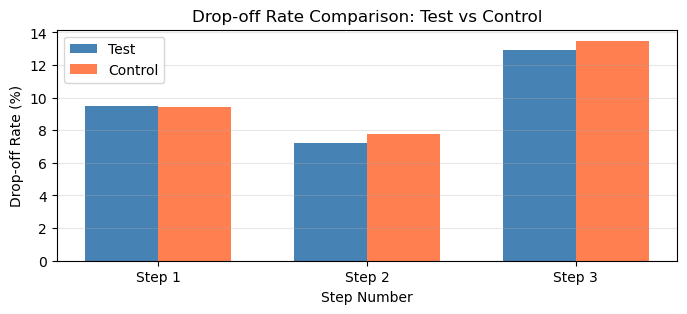

In [32]:
# Create comparison chart
steps = list(range(1, len(test_dropoff_rates) + 1))

plt.figure(figsize=(8, 3))
x = np.arange(len(steps))
width = 0.35

plt.bar(x - width/2, test_dropoff_rates, width, label='Test', color='steelblue')
plt.bar(x + width/2, control_dropoff_rates, width, label='Control', color='coral')

plt.xlabel('Step Number')
plt.ylabel('Drop-off Rate (%)')
plt.title('Drop-off Rate Comparison: Test vs Control')
plt.xticks(x, [f'Step {s}' for s in steps])
plt.legend()
plt.grid(axis='y', alpha=0.3)

plt.show()

In [34]:
# Print comparison --> step by step

for i, step in enumerate(steps):
    diff = test_dropoff_rates[i] - control_dropoff_rates[i]
    print(f"Step {step}: Test={test_dropoff_rates[i]:.1f}% | Control={control_dropoff_rates[i]:.1f}% | Difference={diff:+.1f}%")

Step 1: Test=9.5% | Control=9.4% | Difference=+0.1%
Step 2: Test=7.2% | Control=7.8% | Difference=-0.6%
Step 3: Test=12.9% | Control=13.5% | Difference=-0.6%


In [40]:
print(f"\nAverate drop off")

# Average drop-off for Test
mean_test = np.mean(test_dropoff_rates)
print(f"Test: {mean_test:.2f}%")

# Average drop-off for Control
mean_control = np.mean(control_dropoff_rates)
print(f"Control: {mean_control:.2f}%")

# Difference
diff = mean_test - mean_control
print(f"\nDifference: {diff:+.2f}%")

if diff < 0:
    print(f"Test has {abs(diff):.2f}% less drop-off than Control")
else:
    print(f"Test has {diff:.2f}% more drop-off than Control")


Averate drop off
Test: 9.86%
Control: 10.22%

Difference: -0.36%
Test has 0.36% less drop-off than Control


In [43]:
# Create summary
summary = pd.DataFrame({
    'Metric': ['Average Drop-off (%)', 'Max Drop-off (%)', 'Min Drop-off (%)'],'Test': [mean_test,max(test_dropoff_rates),min(test_dropoff_rates)],
    'Control': [mean_control,max(control_dropoff_rates),min(control_dropoff_rates)]})

summary['Difference'] = summary['Test'] - summary['Control']
print("\nSummary")
print(summary)


SUMMARY
                 Metric       Test    Control  Difference
0  Average Drop-off (%)   9.863600  10.222634   -0.359034
1      Max Drop-off (%)  12.906956  13.489119   -0.582163
2      Min Drop-off (%)   7.198283   7.772841   -0.574558


In [49]:
final_per_step_df.head(1)

,client_id,visitor_id,visit_id,process_step,date_time,process_step_num,step_diff,step_anomaly,next_time,duration_seconds,...,clnt_tenure_mnth,clnt_age,gendr,num_accts,bal,calls_6_mnth,logons_6_mnth,is_error,is_dropoff,Variation_y
0,555,402506806_56087378777,637149525_38041617439_716659,start,2017-04-15 12:57:56,0,NaN,False,2017-04-15 12:58:03,7.0,...,46.0,29.5,U,2.0,25454.66,2.0,6.0,False,False,Test


In [51]:
VANGUARD_PALETTE = {
    "red":      "#96151D",  # anchor
    "charcoal": "#222222",
    "slate":    "#4B5563",
    "steel":    "#64748B",
    "blue":     "#1F4E79",
    "teal":     "#0F766E",
    "gold":     "#B08900",
    "light":    "#E5E7EB",
}

# handy ordered list for seaborn/matplotlib
VANGUARD_COLORS = [
    VANGUARD_PALETTE["red"],
    VANGUARD_PALETTE["blue"],
    VANGUARD_PALETTE["teal"],
    VANGUARD_PALETTE["gold"],
    VANGUARD_PALETTE["slate"],
    VANGUARD_PALETTE["steel"],
    VANGUARD_PALETTE["charcoal"],
    VANGUARD_PALETTE["light"],
]

In [50]:
dropoff_per_step = final_per_step_df.groupby(["Variation_y", "process_step"])["is_dropoff"].mean()
dropoff_per_step

Variation_y  process_step
Control      confirm         0.000000
             start           0.167665
             step_1          0.098791
             step_2          0.043461
             step_3          0.081738
Test         confirm         0.000000
             start           0.133788
             step_1          0.061842
             step_2          0.028567
             step_3          0.055615
Name: is_dropoff, dtype: float64

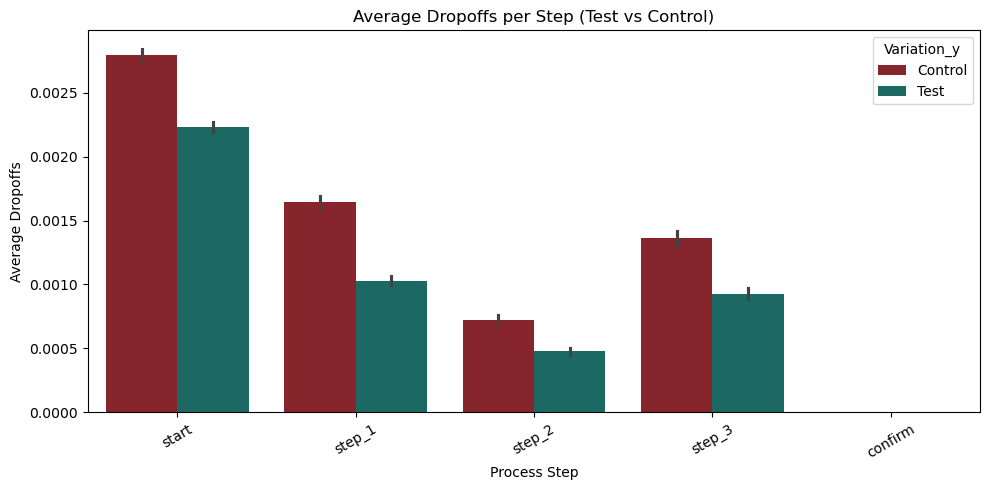

In [52]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
sns.barplot(
    data=final_per_step_df,
    x="process_step",
    y=final_per_step_df["is_dropoff"] / 60,
    hue="Variation_y",
    hue_order=["Control", "Test"],   # key line
    palette=[VANGUARD_PALETTE["red"], VANGUARD_PALETTE["teal"]]
)

plt.title("Average Dropoffs per Step (Test vs Control)")
plt.xlabel("Process Step")
plt.ylabel("Average Dropoffs")
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()

In [54]:
# Check if there are any dropoffs at confirm, by group
confirm_dropoffs = (
    final_per_step_df[final_per_step_df["process_step"] == "confirm"]
    .groupby("Variation_y")["is_dropoff"]
    .agg(dropoff_count="sum", confirm_rows="count", dropoff_rate="mean")
)

confirm_dropoffs

,dropoff_count,confirm_rows,dropoff_rate
Variation_y,,,
Control,0,20019,0.0
Test,0,31379,0.0


- KPI #7: Error rate per step: how often users move backward or hit errors.

- KPI #8: Anomaly rate: irregular step jumps or session fragmentation, indicate improper use of the UI.